### 数据预处理
#### 1、缺失值填充
1、均值填充法

In [6]:
import pandas as pd
import numpy as np
from numpy import nan as NaN
df = pd.DataFrame([[1,2,3],[NaN,4,6],[NaN,3,NaN]])
print(df)
for column in list(df.columns[df.isnull().sum() > 0]):
    mean_val = df[column].mean()
    df[column].fillna(mean_val, inplace=True)
df

,0,1,2
0,1.0,2,3.0
1,1.0,4,6.0
2,1.0,3,4.5


2、回归填充法
使用sklearn库的函数IterativeImputer,下面代码的estimator参数为选择缺失值填补算法

In [10]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer
from sklearn.linear_model import BayesianRidge
imp_mean = IterativeImputer(estimator=BayesianRidge())             
X = [[np.nan, 2, 3], 
     [4, 4, 6], 
     [10, np.nan, 9]]
imp_mean.fit(X)
imp_mean.transform(X)

array([[-1.9976995 ,  2.        ,  3.        ],
       [ 4.        ,  4.        ,  6.        ],
       [10.        ,  6.00061061,  9.        ]])

3、k近邻填充法

In [11]:
from sklearn.impute import KNNImputer
# 代码取自Sklearn用户指南
X = [[1, 2, np.nan], 
     [3, 4, 3], 
     [np.nan, 6, 5], 
     [8, 8, 7]]
imputer = KNNImputer(n_neighbors=2)
imputer.fit_transform(X)

array([[1. , 2. , 4. ],
       [3. , 4. , 3. ],
       [5.5, 6. , 5. ],
       [8. , 8. , 7. ]])

#### 2、异常值检测

1、3$\sigma$准则（需要数据满足正态分布）
下面函数输入为需要检测的一列数据，输出为异常值及其所在行数

In [ ]:
import numpy as np
import pandas as pd
def three_sigma(ser):
    '''
    ser参数：被检测的数据，接收DataFrame的一列数据
    返回：异常值及其对应的行索引
    '''
    # 计算平均值
    mean_data=ser.mean()
    # 计算标准差
    std_data=ser.std()
    # 小于μ-3σ或大于μ+3σ的数据均为异常值
    rule=(mean_data-3*std_data > ser) | (mean_data+3*std_data < ser)
    # 然后np.arange方法生成一个从0开始，到ser长度-1结束的连续索引，再根据rule列表中的True值，直接保留所有为True的索引，也就是异常值的行索引
    index=np.arange(ser.shape[0])[rule]
    # 获取异常值
    outliers=ser.iloc[index]
    return outliers

2、箱型线检测法
分两步：（1）、绘制箱型线图（2）、找到异常值

2   -100
6    200
Name: Score, dtype: int64

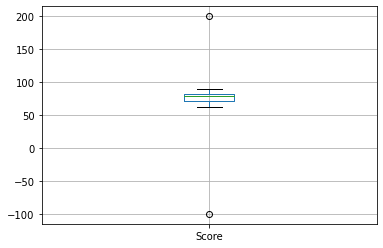

In [16]:
import pandas as pd

def box_outliers(ser):
    #对待检测的数据集进行排序
    new_ser=ser.sort_values()
    # 判断数据的总数量是奇数还是偶数
    if new_ser.count()%2==0 :
        #计算Q3，Q1,IQR
        Q3=new_ser[int(len(new_ser)/2):].median()
        Q1=new_ser[:int(len(new_ser)/2)].median()
    elif new_ser.count()%2 !=0 :
        Q3=new_ser[int(len(new_ser)/2-1):].median()
        Q1=new_ser[:int(len(new_ser)/2-1)].median()
    IQR=round(Q3-Q1,1)
    rule=(round(Q3+1.5*IQR,1)<ser) | (round(Q1-1.5*IQR,1)>ser)
    index=np.arange(ser.shape[0])[rule]
    #获取异常值及其索引
    outliers=ser.iloc[index]
    return outliers


data = pd.DataFrame({
    'Number':[0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15],
    'Score':[86,67,-100,62,79,84,200,82,80,90,72,79,79,75,71,79]
})
data.boxplot(column='Score')
box_outliers(data['Score'])


## 回归分析

### 数据检验

#### 1、多重共线性检验
检测模型中自变量之间是否存在较高的线性相关关系，若存在会给模型带来严重的后果。其检验可以通过方差膨胀因子VIF来鉴定。
该方法分别以每个解释变量为被解释变量，作与其他解释变量的回归。以为$X_j$被解释变量作对其他解释变量辅助线性回归的可决系数用$R_j^2$表示，解释变量$X_j$参数估计值$\hat{\beta _j}$的方差可表示为
$$
Var(\hat{\beta _j}) = \dfrac{\sigma ^2}{\sum x_j^2}\dfrac{1}{1-R_j^2}=\dfrac{\sigma ^2}{\sum x_j^2}VIF_j
$$
其中$VIF_j$是变量$X_j$的方差扩大因子，即
$$
VIF_j=\dfrac{1}{1-R_j^2}
$$
一般来说，若$VIF_j\geq 10$，则说明该解释变量与其余解释变量之间有比较严重的多重共线性。

In [6]:
from sklearn import datasets
from sklearn import model_selection
import statsmodels.api as sm
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
boston_data = datasets.load_boston()
data = pd.DataFrame(boston_data.data)
data.columns = ['CRIM','ZN','INDUS','CHAS','NOX','RM','AGE','DIS','RAD','TAX','PTRATTO','B','LSTAT']
target = pd.DataFrame(boston_data.target)
target.columns = ['MEDV']
data_boston = pd.concat([data,target],axis=1)
print(data_boston.head(3))

      CRIM    ZN  INDUS  CHAS    NOX     RM   AGE     DIS  RAD    TAX  \
0  0.00632  18.0   2.31   0.0  0.538  6.575  65.2  4.0900  1.0  296.0   
1  0.02731   0.0   7.07   0.0  0.469  6.421  78.9  4.9671  2.0  242.0   
2  0.02729   0.0   7.07   0.0  0.469  7.185  61.1  4.9671  2.0  242.0   

   PTRATTO       B  LSTAT  MEDV  
0     15.3  396.90   4.98  24.0  
1     17.8  396.90   9.14  21.6  
2     17.8  392.83   4.03  34.7  


In [7]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
X = sm.add_constant(data)
vif = pd.DataFrame()
vif['features'] = X.columns
vif["VIF Factor"] = [variance_inflation_factor(X.values,i) for i in range(X.shape[1])]
vif

C:\Users\22910\anaconda3\lib\site-packages\statsmodels\tsa\tsatools.py:142: FutureWarning: In a future version of pandas all arguments of concat except for the argument 'objs' will be keyword-only
  x = pd.concat(x[::order], 1)


,features,VIF Factor
0,const,585.265238
1,CRIM,1.792192
2,ZN,2.298758
3,INDUS,3.991596
4,CHAS,1.073995
5,NOX,4.393720
6,RM,1.933744
7,AGE,3.100826
8,DIS,3.955945
9,RAD,7.484496


第一行const一般只参与计算，不参与比较，可以看到，所有变量VIF值均在10以内，基本不存在共线性。\
若存在多重共线性问题，可进行变量筛选或者使用逐步回归进行辅助筛选。

#### 2、线性相关性检验
图形法

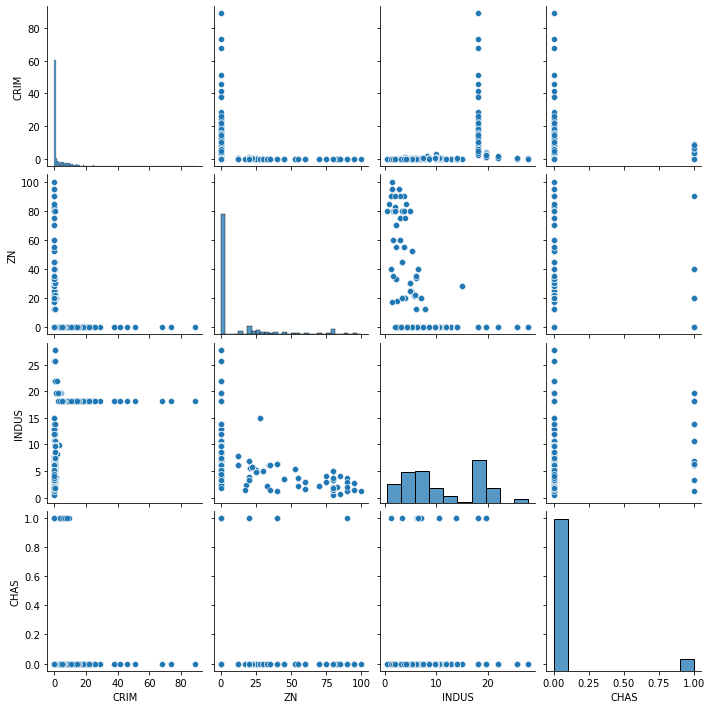

In [8]:
import seaborn as sns
import scipy.stats as stats
sns.pairplot(data_boston.iloc[:,[0,1,2,3]]) #去除哑变量
plt.show()

可以看到选取的各变量之间散点图呈水平趋势，说明基本不存在相关关系
(也可以看相关系数)

#### 3、模型显著性检验-F检验
统计量:
$$
F=\dfrac{SSR/p}{SSE/(n-p-1)}\sim F(p,n-p-1)
$$
其中，$SSE=\sum_{i=1}^{n}(y_i-\hat{y_i})^2$为误差平方和,$SSR=\sum_{i=1}^{n}(\hat{y_i}-\overline{y})^2$为回归离差平方和，p表示自变量个数，n表示观测值个数。 \
假设:
$$
\begin{cases}
H_0:\beta _0=\beta _1=\dots =\beta _p=0 \\
H_1:\beta _0、\beta _1、\dots 、\beta _p不全为0 
\end{cases}
$$

#### 4、回归系数显著性检验-t检验
统计量:
$$
t_j=\dfrac{\hat{\beta _j}-\beta _j}{\sqrt{c_{jj}}\hat{\sigma}}\sim t(n-p-1)
$$
其中，$c_{jj}$为$(X^TX)^{-1}$的第$j$个对角线元素，$\hat{\sigma}=\sqrt{\frac{SSE}{n-p-1}}$ \
假设:
$$
\begin{cases}
H_0:\beta _j=0,j=1,2,\dots ,p \\
H_1:\beta _j\neq 0
\end{cases}
$$

In [9]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(data, target, test_size=0.2, random_state=0)
data_train = pd.concat([x_train,y_train],axis=1)
data_train

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATTO,B,LSTAT,MEDV
220,0.35809,0.0,6.20,1.0,0.507,6.951,88.5,2.8617,8.0,307.0,17.4,391.70,9.71,26.7
71,0.15876,0.0,10.81,0.0,0.413,5.961,17.5,5.2873,4.0,305.0,19.2,376.94,9.88,21.7
240,0.11329,30.0,4.93,0.0,0.428,6.897,54.3,6.3361,6.0,300.0,16.6,391.25,11.38,22.0
6,0.08829,12.5,7.87,0.0,0.524,6.012,66.6,5.5605,5.0,311.0,15.2,395.60,12.43,22.9
417,25.94060,0.0,18.10,0.0,0.679,5.304,89.1,1.6475,24.0,666.0,20.2,127.36,26.64,10.4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
323,0.28392,0.0,7.38,0.0,0.493,5.708,74.3,4.7211,5.0,287.0,19.6,391.13,11.74,18.5
192,0.08664,45.0,3.44,0.0,0.437,7.178,26.3,6.4798,5.0,398.0,15.2,390.49,2.87,36.4
117,0.15098,0.0,10.01,0.0,0.547,6.021,82.6,2.7474,6.0,432.0,17.8,394.51,10.30,19.2
47,0.22927,0.0,6.91,0.0,0.448,6.030,85.5,5.6894,3.0,233.0,17.9,392.74,18.80,16.6


In [10]:
model = sm.formula.ols('MEDV~CRIM+ZN+INDUS+CHAS+NOX+RM+AGE+DIS+RAD+TAX+PTRATTO+B+LSTAT',data=data_train).fit()
model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.773
Model:                            OLS   Adj. R-squared:                  0.765
Method:                 Least Squares   F-statistic:                     102.2
Date:                Thu, 08 Sep 2022   Prob (F-statistic):          9.64e-117
Time:                        10:52:17   Log-Likelihood:                -1171.5
No. Observations:                 404   AIC:                             2371.
Df Residuals:                     390   BIC:                             2427.
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     38.0917      5.522      6.898      0.000      27.234      48.949
CRIM          -0.1194      0.037     -3.257      0.001      -0.192      -0.047
ZN             0.0448      0.014      3.102      0.002       0.016       0.073
INDUS          0.0055      0.063      0.087      0.931      -0.119       0.130
CHAS           2.3408      0.902      2.595      0.010       0.567       4.115
NOX          -16.1236      4.212     -3.828      0.000     -24.404      -7.843
RM             3.7087      0.458      8.106      0.000       2.809       4.608
AGE           -0.0031      0.014     -0.218      0.828      -0.031       0.025
DIS           -1.3864      0.214     -6.480      0.000      -1.807      -0.966
RAD            0.2442      0.070      3.481      0.001       0.106       0.382
TAX           -0.0110      0.004     -2.819      0.005      -0.019      -0.003
PTRATTO       -1.0459      0.137     -7.636      0.000      -1.315      -0.777
B              0.0081      0.003      2.749      0.006       0.002       0.014
LSTAT         -0.4928      0.054     -9.086      0.000      -0.599      -0.386
==============================================================================
Omnibus:                      141.494   Durbin-Watson:                   1.996
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              629.882
Skew:                           1.470   Prob(JB):                    1.67e-137
Kurtosis:                       8.365   Cond. No.                     1.55e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

通过上面的summary可以知道模型显著性较强，INDUS和AGE回归系数显著性较弱。

#### 5、异常样本检验
#####  （1）帽子矩阵
帽子矩阵考察的是第$i$个样本对观测值$\hat{y}$的影响大小
$$
\hat{y}=X\hat{\beta}=X(X^TX)^{-1}X^Ty=Hy
$$
其中$H=X(X^TX)^{-1}X^T$就是帽子矩阵，样本为异常值的判断方法为:
$$
h_{ii}\ge \dfrac{2(p+1)}{n}
$$
其中$h_{ii}$为帽子矩阵H的第$i$个主对角线元素，p为自变量个数，n为样本数。
##### （2）DFFITS准则
该统计量同样根据帽子矩阵构造:
$$
D_j(\sigma)=\sqrt{\dfrac{h_{ii}}{1-h_{ii}}}\dfrac{\varepsilon _i}{\sigma \sqrt{1-h_{ii}}}
$$
其中$\varepsilon _i$为第$i$个样本点的预测误差，$\varepsilon$为误差项的标准差，样本异常值的判断方法为:
$$
|D_j(\sigma)|>2\sqrt{\dfrac{p+1}{n}}
$$
##### （3）学生化残差
判断方法为
$$
r_i=\dfrac{\varepsilon _i}{\sigma \sqrt{1-h_{ii}}}>2
$$
##### （4）Cook距离
Cook距离没有具体的临界值判断样本是否为异常点，Cook统计量越大，是异常点的可能性越大。
$$
Distance_i=\dfrac{1}{p+1}(\dfrac{h_{ii}}{1-h_{ii}})r_i^2
$$
其中$r_i$为学生化残差

In [11]:
#异常值检验
outliers=model.get_influence()

#帽子矩阵
leverage=outliers.hat_matrix_diag
#DFFITS值
dffits=outliers.dffits[0]
#学生化残差
resid_stu=outliers.resid_studentized_external
#cook距离
cook=outliers.cooks_distance[0]
#合并各种异常值检验的统计量值
contat1=pd.concat([pd.Series(leverage,name='leverage'),pd.Series(dffits,name='dffits'),
                   pd.Series(resid_stu,name='resid_stu'),pd.Series(cook,name='cook')],axis=1)
data_train.index = range(data_train.shape[0])
#合并数据和异常值
pred_outliers=pd.concat([data_train,contat1],axis=1)

#计算异常值数量的比例，以学生化残差为例
outliers_ratio=sum(np.where((np.abs(pred_outliers.resid_stu)>2),1,0))/data_train.shape[0]
print(outliers_ratio)

0.04950495049504951


一般来说，若异常样本比例小于5%，可以直接删除 \
下面使用非异常样本进行建模

In [14]:
none_outliers = pred_outliers.loc[np.abs(pred_outliers.resid_stu)<=2]
model2 = sm.formula.ols('MEDV~CRIM+ZN+CHAS+NOX+RM+DIS+RAD+TAX+PTRATTO+B+LSTAT',data=none_outliers).fit()
model2.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                   MEDV   R-squared:                       0.853
Model:                            OLS   Adj. R-squared:                  0.848
Method:                 Least Squares   F-statistic:                     195.8
Date:                Thu, 08 Sep 2022   Prob (F-statistic):          3.11e-147
Time:                        11:40:57   Log-Likelihood:                -984.10
No. Observations:                 384   AIC:                             1992.
Df Residuals:                     372   BIC:                             2040.
Df Model:                          11                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     21.7771      4.321      5.039      0.000      13.280      30.274
CRIM          -0.1316      0.027     -4.861      0.000      -0.185      -0.078
ZN             0.0437      0.010      4.164      0.000       0.023       0.064
CHAS           1.4907      0.689      2.165      0.031       0.137       2.845
NOX          -10.3269      2.830     -3.650      0.000     -15.891      -4.763
RM             4.7143      0.378     12.473      0.000       3.971       5.457
DIS           -0.9461      0.148     -6.376      0.000      -1.238      -0.654
RAD            0.2043      0.049      4.195      0.000       0.109       0.300
TAX           -0.0119      0.003     -4.702      0.000      -0.017      -0.007
PTRATTO       -0.9057      0.098     -9.233      0.000      -1.099      -0.713
B              0.0111      0.002      5.180      0.000       0.007       0.015
LSTAT         -0.3677      0.040     -9.101      0.000      -0.447      -0.288
==============================================================================
Omnibus:                       14.768   Durbin-Watson:                   2.076
Prob(Omnibus):                  0.001   Jarque-Bera (JB):               15.399
Skew:                           0.478   Prob(JB):                     0.000453
Kurtosis:                       3.218   Cond. No.                     1.58e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.58e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

#### 6、残差独立性检验
通过summary观察Durbin-Watson的值即可，一般为2左右即说明残差之间具有独立性

####  7、残差的方差齐性检验
检验残差项的方差不受自变量的变化而影响 \
图形法:

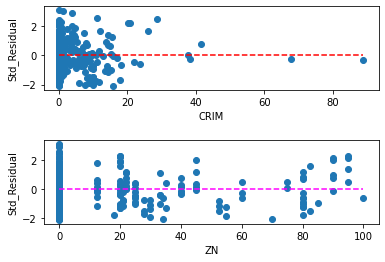

In [15]:
ax1 = plt.subplot2grid(shape = (2,1) , loc = (0,0)) # 设置第一张子图位置
# 散点图绘制
ax1.scatter(none_outliers.CRIM, (model2.resid - model2.resid.mean())/model2.resid.std()) #标准化残差和自变量散点图
# 添加水平参考线
ax1.hlines(y = 0 ,
          xmin = none_outliers.CRIM.min(),
           xmax = none_outliers.CRIM.max(),
           color = 'red',
           linestyle = '--'
          )
ax1.set_xlabel('CRIM')
ax1.set_ylabel('Std_Residual')
ax2 = plt.subplot2grid(shape = (2,1) , loc = (1,0))
ax2.scatter(none_outliers.ZN, (model2.resid - model2.resid.mean())/model2.resid.std())
ax2.hlines(y = 0 ,
          xmin = none_outliers.ZN.min(),
           xmax = none_outliers.ZN.max(),
           color = 'magenta',
           linestyle = '--'
          )
ax2.set_xlabel('ZN')
ax2.set_ylabel('Std_Residual')
 
# 调整2子图之间距离
plt.subplots_adjust(hspace = 0.6,wspace = 0.3)
plt.show()

BP法（拉格朗日乘子检验）

In [19]:
print(sm.stats.diagnostic.het_breuschpagan(model2.resid,exog_het=model2.model.exog))

(48.37255177947496, 1.2250376927223068e-06, 4.874070222089953, 4.714676841609054e-07)


上述四个变量分别为LM统计量，p值，F统计量，F统计量的p值，一般来讲p值均小于0.05，证明接受残差方差齐性原假设，即说明残差不受自变量的影响而变化
如果残差不满足齐性，可以用两种方法解决：一是模型变换法，即考虑残差与自变量之间的关系，如果残差与自变量x成正比，模型两边同时除以$\sqrt{x}$如果残差与自变量x的平方成正比，模型两边同时除以x；二是加权最小二乘法，用三种权重进行对比测试(残差绝对值的倒数作为权重、残差平方的倒数作为权重、残差的平方对数与自变量x重新拟合建模得到的拟合值取指数，用指数的倒数作为权重)